<a href="https://colab.research.google.com/github/mardmikon/-Intelligent-systems-and-technologies/blob/main/%D0%97%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_13_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Задание 13-16**

**Выполнить исследование и сравнительный анализ возможностей RNN,
LSTM и GRU**

In [87]:
import keras
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, SimpleRNN, GRU, Activation
%matplotlib inline

Прием данных - чтение наборов данных из объекта Azure

In [88]:
# Data ingestion - reading the datasets from Azure blob 
!wget http://azuremlsamples.azureml.net/templatedata/PM_train.txt 
!wget http://azuremlsamples.azureml.net/templatedata/PM_test.txt
!wget http://azuremlsamples.azureml.net/templatedata/PM_truth.txt 

--2021-12-29 14:32:42--  http://azuremlsamples.azureml.net/templatedata/PM_train.txt
Resolving azuremlsamples.azureml.net (azuremlsamples.azureml.net)... 13.107.246.69, 13.107.213.69, 2620:1ec:bdf::69, ...
Connecting to azuremlsamples.azureml.net (azuremlsamples.azureml.net)|13.107.246.69|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3515356 (3.4M) [text/plain]
Saving to: ‘PM_train.txt.1’

PM_train.txt.1      100%[===================>]   3.35M  21.7MB/s    in 0.2s    

2021-12-29 14:32:42 (21.7 MB/s) - ‘PM_train.txt.1’ saved [3515356/3515356]

--2021-12-29 14:32:42--  http://azuremlsamples.azureml.net/templatedata/PM_test.txt
Resolving azuremlsamples.azureml.net (azuremlsamples.azureml.net)... 13.107.246.69, 13.107.213.69, 2620:1ec:bdf::69, ...
Connecting to azuremlsamples.azureml.net (azuremlsamples.azureml.net)|13.107.246.69|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2228855 (2.1M) [text/plain]
Saving to: ‘PM_test.txt.1’

PM_te

Чтение обучающих данных

In [89]:
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

Чтение тестовых данных

In [90]:
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

Чтение достоверных данных

In [91]:
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [92]:
train_df = train_df.sort_values(['id','cycle'])
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


**Предварительная обработка данных**

> Первый шаг - сгенерировать метки для данных обучения: RUL, label1 и label2



In [93]:
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


Генерация меток для обучающих данных

In [94]:
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0,0


МинМакс нормализация столбцов в обучающих данных

In [95]:
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,1.0,0.726248,0.242424,0.109755,0.0,0.369048,0.633262,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,1.0,0.628019,0.212121,0.100242,0.0,0.380952,0.765458,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,1.0,0.710145,0.272727,0.140043,0.0,0.250000,0.795309,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,1.0,0.740741,0.318182,0.124518,0.0,0.166667,0.889126,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,1.0,0.668277,0.242424,0.149960,0.0,0.255952,0.746269,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


Подготовка тестовых данных. Сначала нормализуются тестовые данные, используя параметры из нормализации МинМакс, примененной к обучающим данным.

In [96]:
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,1.0,0.652174,0.212121,0.127614,0.0,0.208333,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,1.0,0.805153,0.166667,0.146684,0.0,0.386905,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,1.0,0.685990,0.227273,0.158081,0.0,0.386905,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,1.0,0.679549,0.196970,0.105717,0.0,0.255952,0.573561,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,1.0,0.694042,0.166667,0.102396,0.0,0.273810,0.737740,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108


Использование набора достоверных данных для создания меток для тестовых данных

Генерация столбца Макс для тестовых данных

In [97]:
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

Генерация RUL для тестовых данных

In [98]:
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,1.0,0.652174,0.212121,0.127614,0.0,0.208333,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,1.0,0.805153,0.166667,0.146684,0.0,0.386905,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,1.0,0.685990,0.227273,0.158081,0.0,0.386905,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,1.0,0.679549,0.196970,0.105717,0.0,0.255952,0.573561,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,1.0,0.694042,0.166667,0.102396,0.0,0.273810,0.737740,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138


Генерация меток столбцов w0 и w1 для тестовых данных

In [99]:
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1,label2
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,1.0,0.652174,0.212121,0.127614,0.0,0.208333,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,1.0,0.805153,0.166667,0.146684,0.0,0.386905,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,1.0,0.685990,0.227273,0.158081,0.0,0.386905,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,1.0,0.679549,0.196970,0.105717,0.0,0.255952,0.573561,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,1.0,0.694042,0.166667,0.102396,0.0,0.273810,0.737740,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0,0


**Моделирование**

Выбор размера окна в 50 циклов 

In [100]:
sequence_length = 50

Подготовка данных для визуализаций. Окно в 50 циклов до точки отказа для двигателя с ID 18 в соответствии с вариантом.

In [101]:
engine_id18 = test_df[test_df['id'] == 18]
engine_id18_50cycleWindow = engine_id18[engine_id18['RUL'] <= engine_id18['RUL'].min() + 50]
cols1 = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
engine_id18_50cycleWindow1 = engine_id18_50cycleWindow[cols1]
cols2 = ['s11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
engine_id18_50cycleWindow2 = engine_id18_50cycleWindow[cols2]

Построение данных датчиков для двигателя ID 18 до точки отказа - датчики 1-10

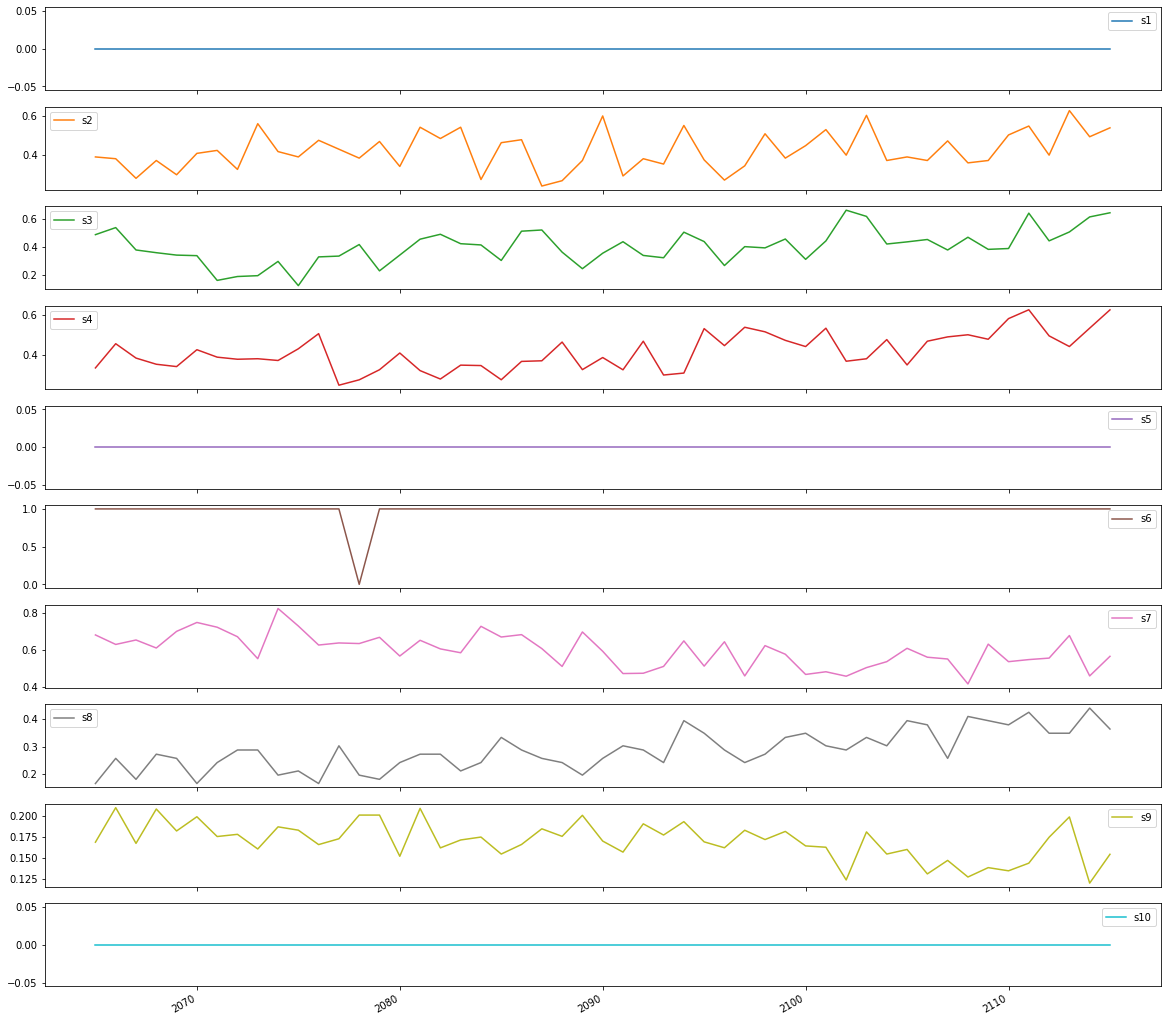

In [102]:
ax1 = engine_id18_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

Построение данных датчиков для двигателя ID 18 до точки отказа - датчики 11-21

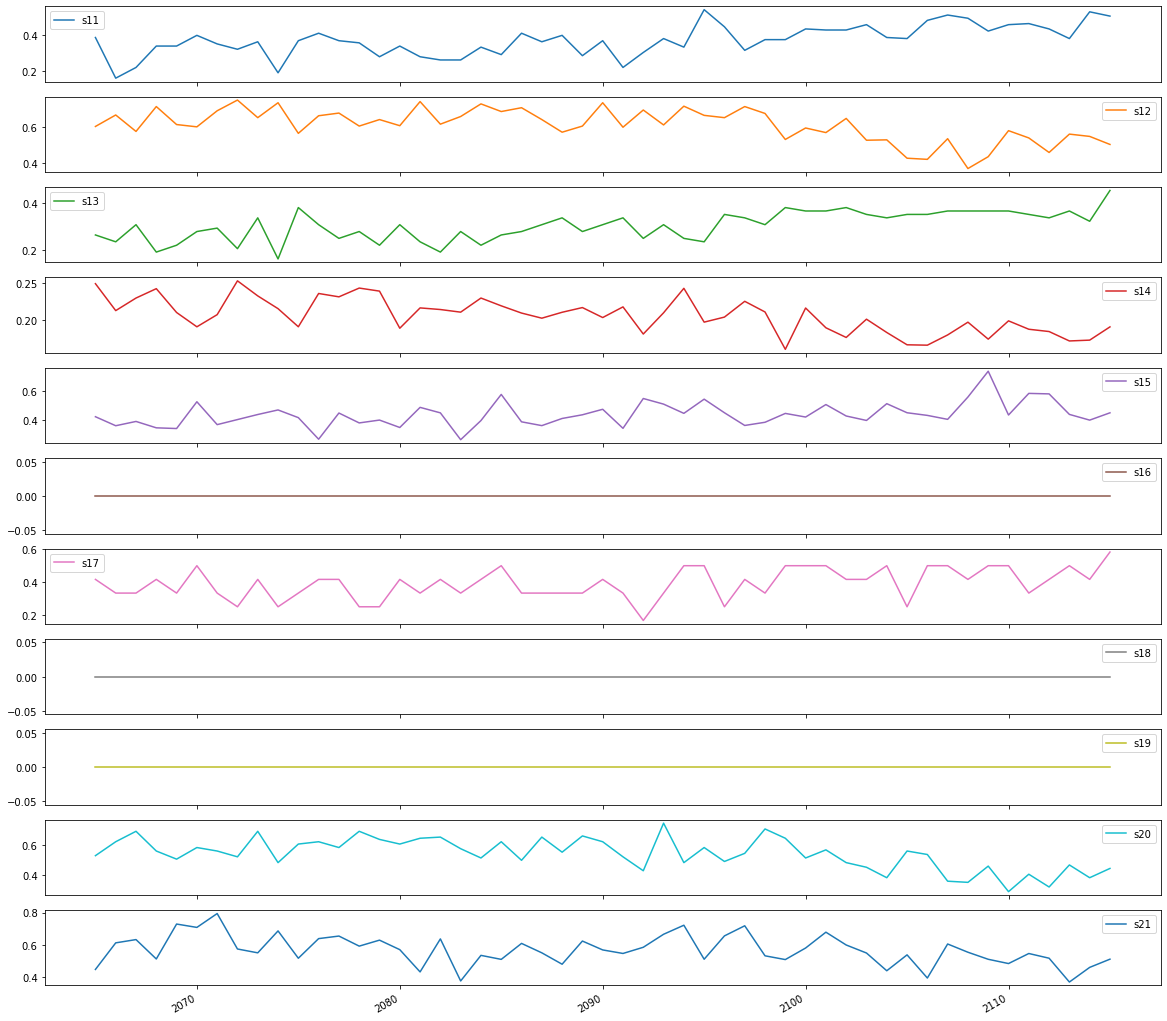

In [103]:
ax2 = engine_id18_50cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20))

Слои Keras LSTM ожидают ввода в виде массива из трех измерений (образцы, временные шаги, признаки), где образцы - это количество обучающих последовательностей, временные шаги - это окно ретроспективного обзора или длина последовательности, а признаки - это количество признаков каждой последовательности на каждом временном шаге.

Функция для преобразования признаков в (образцы, временные шаги, признаки)

In [104]:
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

Выбор столбцов признаков

In [105]:
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

Генератор последовательностей

In [106]:
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

генерация последовательности и преобразование в массив numpy

In [107]:
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(15631, 50, 25)

Функция для создания меток

In [108]:
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

Генерация меток

In [109]:
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

**Сеть LSTM**

Построение сети. Первый уровень - это уровень LSTM со 100 единицами, за которым следует еще один уровень LSTM с 50 единицами. Исключение также применяется после каждого уровня LSTM для контроля переобучения. Последний слой - это плотный выходной слой с активацией одного элемента и сигмовидной формы.


> *Sequential* - предназначен для создания группы слоев, на которых будет основана модель нейронной сети


> *add* - добавление слоя к последовательности

> *LSTM* - слой долгой краткосрочной памяти, способный к обучению долговременным зависимостям:
*   input_shape - размер входного пакета
*   units - выходной параметр слоя, являющийся входом в следующий слой
*   return_sequences - возвращение последовательности для входа в следующий слой при значении True

> *Dropout* - устанока случайным образом для входных единиц значения 0 с частотой (0.2) на каждом шаге во время обучения для контроля переобучения

> *Dense* - полносвязный слой нейросети:
*   units - выходной параметр слоя
*   activation - функция активации слоя (сигмоида, возвращающая значения от 0 до 1)

> *compile* - настройка модели для обучения:
*   loss - функция потерь (binary_crossentropy)
*   optimizer - оптимизатор (adam - среднее значение вторых моментов градиентов)
*   metrics - функция оценки производительности модели (accuracy)

In [110]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [111]:
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 100)           50400     
                                                                 
 dropout_10 (Dropout)        (None, 50, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_11 (Dropout)        (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None


**Подсчет числа параметров:**

lstm (LSTM) : 4 * (размер входа + 1) * размер выхода + размер выхода ^2) = 4 * (25 + 1) * 100 + 100^2) = 50400

lstm_1 (LSTM) : 4 * (размер входа + 1) * размер выхода + размер выхода ^2) = 4 * (100 + 1) * 50 + 50^2) = 30200

dense (Dense) : размер выхода * (размер входа + 1) = 1 * (50 + 1) = 51

Dropout = 0, т.к. данные слои не обучаются

**Итог:** Общее число параметров (Total params) равно числу параметров в слоях (Trainable params)


**Оценка времени выполнения LSTM на CPU**

In [113]:
cpuTimeLSTM = time.time()
# fit the network
history = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
cpuTimeLSTM = time.time() - cpuTimeLSTM
print(f"Время выполнения LSTM на CPU составляет: {cpuTimeLSTM}")

Epoch 1/10
75/75 [==============================] - 30s 403ms/step - loss: 0.0780 - accuracy: 0.9678 - val_loss: 0.0585 - val_accuracy: 0.9706
Epoch 2/10
75/75 [==============================] - 20s 262ms/step - loss: 0.0698 - accuracy: 0.9695 - val_loss: 0.0622 - val_accuracy: 0.9744
Время выполнения LSTM на CPU составляет: 49.96708607673645



> *fit* - обучение модели:
*   seq_array (характеристики с сенсоров) - входные данные
*   label_array (метки выхода из строя) - целевые данные
*   epochs - количество эпох обучения
*   batch_size - количество выборок, распространяющихся по сети
*   validation_split - часть обучающих данных, использующаяся в качестве данных проверки.
*   verbose - режим детализации (0 = ничего, 1 = индикатор выполнения, 2 = одна строка на эпоху)
*   callbacks - список обратных вызовов (EarlyStopping)

> *EarlyStopping* - ранняя остановка:
*   monitor - наблюдаемая величина (потери на валидационной выборке)
*   min_delta - минимальное изменение отслеживаемой величины, квалифицирующееся как улучшение
*   patience - количество эпох без улучшения, после которых обучение будет остановлено
*   verbose - режим детализации
*   mode - остановка обучения при прекращении изменения отслеживаемой величины (val_loss должен уменьшатьтся)

**Оценка времени выполнения LSTM на GPU**

In [218]:
gpuTimeLSTM = time.time()
# fit the network
history = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
gpuTimeLSTM = time.time() - gpuTimeLSTM
print(f"Время выполнения LSTM на GPU составляет: {gpuTimeLSTM}")

Epoch 1/10
75/75 [==============================] - 3s 41ms/step - loss: 0.0510 - accuracy: 0.9776 - val_loss: 0.0706 - val_accuracy: 0.9668
Epoch 2/10
75/75 [==============================] - 3s 43ms/step - loss: 0.0520 - accuracy: 0.9774 - val_loss: 0.0622 - val_accuracy: 0.9680
Время выполнения LSTM на GPU составляет: 6.402385234832764


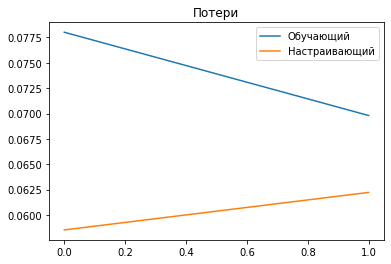

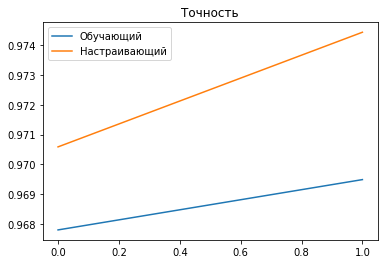

In [114]:
plt.title('Потери')
plt.plot(history.history['loss'], label='Обучающий')
plt.plot(history.history['val_loss'], label='Настраивающий')
plt.legend()
plt.show()

plt.title('Точность')
plt.plot(history.history['accuracy'], label='Обучающий')
plt.plot(history.history['val_accuracy'], label='Настраивающий')
plt.legend()
plt.show()

Показатели обучения

In [115]:
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

79/79 [==============================] - 6s 80ms/step - loss: 0.0879 - accuracy: 0.9618
Accurracy: 0.9618066549301147


Создание прогнозов и вычисление матрицы ошибок

In [116]:
y_pred = (model.predict(seq_array,verbose=1, batch_size=200) > 0.5).astype("int32")
y_true = label_array
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

79/79 [==============================] - 7s 79ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[12387,   144],
       [  453,  2647]])

Вычисление точности и отзыва

In [117]:
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

precision =  0.9484055893944823 
 recall =  0.8538709677419355


Рассмотрение производительности на тестовых данных. Чтобы сравнить результаты с шаблоном, выбирается последняя последовательность для каждого идентификатора в тестовых данных.

In [118]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(93, 50, 25)

In [119]:
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]

Аналогично подбираются метки

In [120]:
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

(93, 1)

In [121]:
print(seq_array_test_last.shape)
print(label_array_test_last.shape)

(93, 50, 25)
(93, 1)


Тестовые показатели

In [122]:
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

3/3 - 0s - loss: 0.0937 - accuracy: 0.9570 - 65ms/epoch - 22ms/step
Accurracy: 0.9569892287254333


Создание прогнозов и вычисление матрицы ошибок

In [123]:
y_pred_test = (model.predict(seq_array_test_last) > 0.5).astype("int32")
y_true_test = label_array_test_last
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
cm

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[67,  1],
       [ 3, 22]])

Вычисление точности и отзыва

In [124]:
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Precision:  0.9565217391304348 
 Recall:  0.88 
 F1-score: 0.9166666666666666


In [125]:
results_df = pd.DataFrame([[scores_test[1],precision_test,recall_test,f1_test]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['LSTM'])
results_df

,Accuracy,Precision,Recall,F1-score
LSTM,0.956989,0.956522,0.88,0.916667


# **RNN**

Построение сети

In [126]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(SimpleRNN(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(SimpleRNN(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 50, 100)           12600     
                                                                 
 dropout_12 (Dropout)        (None, 50, 100)           0         
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 50)                7550      
                                                                 
 dropout_13 (Dropout)        (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 20,201
Trainable params: 20,201
Non-trainable params: 0
_________________________________________________________________
None


**Подсчет числа параметров:**

simple_rnn_2 (SimpleRNN) : (количество прознаков + число единиц) * число единиц + смещение = (25 + 100) * 100 + 100

simple_rnn_3 (SimpleRNN) : (количество прознаков + число единиц) * число единиц + смещение = (100 + 50) * 50 + 50

In [127]:
cpuTimeRNN = time.time()
# fit the network
history = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
cpuTimeRNN = time.time() - cpuTimeRNN
print(f"Время выполнения RNN на CPU составляет: {cpuTimeRNN}")

Epoch 1/10
75/75 [==============================] - 8s 80ms/step - loss: 0.2084 - accuracy: 0.9079 - val_loss: 0.1987 - val_accuracy: 0.9271
Epoch 2/10
75/75 [==============================] - 9s 118ms/step - loss: 0.1166 - accuracy: 0.9506 - val_loss: 0.0600 - val_accuracy: 0.9706
Время выполнения RNN на CPU составляет: 16.60343050956726


In [220]:
gpuTimeRNN = time.time()
# fit the network
history = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
gpuTimeRNN = time.time() - gpuTimeRNN
print(f"Время выполнения RNN на GPU составляет: {gpuTimeRNN}")

Epoch 1/10
75/75 [==============================] - 3s 33ms/step - loss: 0.0466 - accuracy: 0.9808 - val_loss: 0.0532 - val_accuracy: 0.9757
Epoch 2/10
75/75 [==============================] - 2s 33ms/step - loss: 0.0462 - accuracy: 0.9800 - val_loss: 0.0334 - val_accuracy: 0.9821
Время выполнения RNN на GPU составляет: 5.065419435501099


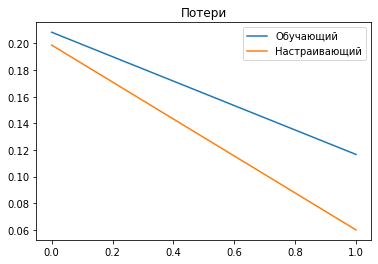

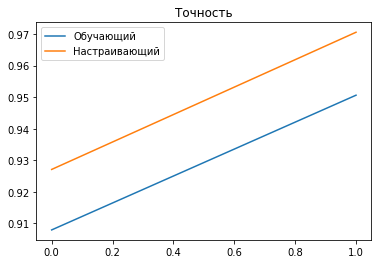

In [128]:
plt.title('Потери')
plt.plot(history.history['loss'], label='Обучающий')
plt.plot(history.history['val_loss'], label='Настраивающий')
plt.legend()
plt.show()

plt.title('Точность')
plt.plot(history.history['accuracy'], label='Обучающий')
plt.plot(history.history['val_accuracy'], label='Настраивающий')
plt.legend()
plt.show()

In [129]:
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

79/79 [==============================] - 4s 53ms/step - loss: 0.0657 - accuracy: 0.9722
Accurracy: 0.9721707105636597


In [130]:
y_pred = (model.predict(seq_array,verbose=1, batch_size=200) > 0.5).astype("int32")
y_true = label_array
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

79/79 [==============================] - 5s 54ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[12400,   131],
       [  304,  2796]])

In [131]:
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

precision =  0.9552442774171507 
 recall =  0.9019354838709678


In [132]:
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

precision =  0.9552442774171507 
 recall =  0.9019354838709678


In [133]:
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]

In [134]:
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

(93, 1)

In [135]:
print(seq_array_test_last.shape)
print(label_array_test_last.shape)

(93, 50, 25)
(93, 1)


In [136]:
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

3/3 - 0s - loss: 0.0601 - accuracy: 0.9785 - 147ms/epoch - 49ms/step
Accurracy: 0.9784946441650391


In [137]:
y_pred_test = (model.predict(seq_array_test_last) > 0.5).astype("int32")
y_true_test = label_array_test_last
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
cm

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[68,  0],
       [ 2, 23]])

In [138]:
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Precision:  1.0 
 Recall:  0.92 
 F1-score: 0.9583333333333334


In [139]:
res = pd.DataFrame([[scores_test[1],precision_test,recall_test,f1_test]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['RNN'])
results_df = results_df.append(res)
results_df

,Accuracy,Precision,Recall,F1-score
LSTM,0.956989,0.956522,0.88,0.916667
RNN,0.978495,1.000000,0.92,0.958333


# **GRU**

In [140]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(GRU(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 50, 100)           38100     
                                                                 
 dropout_14 (Dropout)        (None, 50, 100)           0         
                                                                 
 gru_3 (GRU)                 (None, 50)                22800     
                                                                 
 dropout_15 (Dropout)        (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 60,951
Trainable params: 60,951
Non-trainable params: 0
_________________________________________________________________
None


**Подсчет числа параметров:**

gru_4 (GRU) : ((вход + выход) * выход + выход + выход) * смещение = ((25 + 100) * 100 + 100 + 100) * 3 = 38100

gru_5 (GRU) : ((вход + выход) * выход + выход + выход) * смещение = ((100 + 50) * 50 + 50 + 50) * 3 = 22800

In [141]:
cpuTimeGRU = time.time()
history = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
cpuTimeGRU = time.time() - cpuTimeGRU
print(f"Время выполнения GRU на CPU составляет: {cpuTimeGRU}")

Epoch 1/10
75/75 [==============================] - 37s 325ms/step - loss: 0.2599 - accuracy: 0.8861 - val_loss: 0.1802 - val_accuracy: 0.9284
Epoch 2/10
75/75 [==============================] - 16s 208ms/step - loss: 0.1150 - accuracy: 0.9506 - val_loss: 0.1482 - val_accuracy: 0.9271
Время выполнения GRU на CPU составляет: 52.876636028289795


In [222]:
gpuTimeGRU = time.time()
history = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
gpuTimeGRU = time.time() - gpuTimeGRU
print(f"Время выполнения GRU на GPU составляет: {gpuTimeGRU}")

Epoch 1/10
75/75 [==============================] - 2s 33ms/step - loss: 0.0406 - accuracy: 0.9828 - val_loss: 0.0375 - val_accuracy: 0.9821
Epoch 2/10
75/75 [==============================] - 2s 33ms/step - loss: 0.0413 - accuracy: 0.9826 - val_loss: 0.0344 - val_accuracy: 0.9859
Время выполнения GRU на GPU составляет: 5.008021354675293


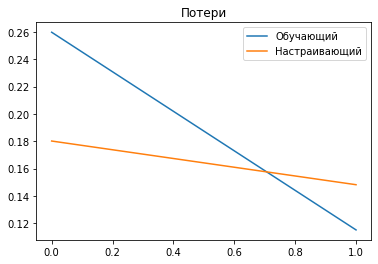

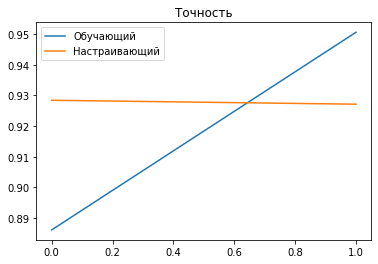

In [143]:
plt.title('Потери')
plt.plot(history.history['loss'], label='Обучающий')
plt.plot(history.history['val_loss'], label='Настраивающий')
plt.legend()
plt.show()

plt.title('Точность')
plt.plot(history.history['accuracy'], label='Обучающий')
plt.plot(history.history['val_accuracy'], label='Настраивающий')
plt.legend()
plt.show()

In [144]:
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

79/79 [==============================] - 10s 126ms/step - loss: 0.1329 - accuracy: 0.9383
Accurracy: 0.9383276700973511


In [145]:
y_pred = (model.predict(seq_array,verbose=1, batch_size=200) > 0.5).astype("int32")
y_true = label_array
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

79/79 [==============================] - 6s 65ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[11616,   915],
       [   49,  3051]])

In [146]:
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

precision =  0.7692889561270801 
 recall =  0.9841935483870968


In [147]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(93, 50, 25)

In [148]:
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]

In [149]:
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

(93, 1)

In [150]:
print(seq_array_test_last.shape)
print(label_array_test_last.shape)

(93, 50, 25)
(93, 1)


In [151]:
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

3/3 - 0s - loss: 0.0757 - accuracy: 0.9677 - 60ms/epoch - 20ms/step
Accurracy: 0.9677419066429138


In [152]:
y_pred_test = (model.predict(seq_array_test_last) > 0.5).astype("int32")
y_true_test = label_array_test_last
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
cm

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[65,  3],
       [ 0, 25]])

In [153]:
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Precision:  0.8928571428571429 
 Recall:  1.0 
 F1-score: 0.9433962264150945


In [154]:
res = pd.DataFrame([[scores_test[1],precision_test,recall_test,f1_test]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['GRU'])
results_df = results_df.append(res)
results_df

,Accuracy,Precision,Recall,F1-score
LSTM,0.956989,0.956522,0.88,0.916667
RNN,0.978495,1.000000,0.92,0.958333
GRU,0.967742,0.892857,1.00,0.943396


<BarContainer object of 6 artists>

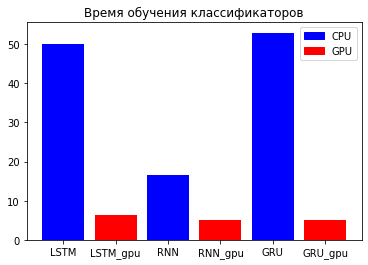

In [158]:
compare_data = [cpuTimeLSTM, 6.402385234832764, cpuTimeRNN, 5.065419435501099, cpuTimeGRU, 5.008021354675293]
axis = ['LSTM', 'LSTM_gpu', 'RNN', 'RNN_gpu', 'GRU', 'GRU_gpu']
plt.title("Время обучения классификаторов")
colors = {'CPU':'blue', 'GPU':'red'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.bar(axis, compare_data, color=['blue', 'red', 'blue', 'red', 'blue', 'red',])

# **Вывод:**

При обучении классификаторов, лучшее время было показано при работе на GPU во всех случаях.

По Accuracy самой оптимальной стала модель с LSTM слоями
По Precision самой оптимальной стала модель с RNN слоями 
По Recall самой оптимальной стала модель с LSTM слоями
По F1-score самой оптимальной стала модель с  LSTM слоями

Таким образом модель со LSTM слоями является лучшей для двигателя  18
